# Tesis <a class="jp-toc-ignore"></a>

## Universidad Nacional Autónoma de México <a class="jp-toc-ignore"></a>

### Facultad de Ciencias <a class="jp-toc-ignore"></a>

Rodrigo Segura Moreno

---

El presente archivo 

## Tabla de contenidos
* [(1) Definiciones](#section1)
    * [(1.1) Función de tipo Slater](#section_1_1)
    * [(1.2) Función de tipo Gaussiana](#section_1_2)
    * [(1.3) Funciones $\ket{1s}$](#section_1_3)
* [(2) Contracción Gaussiana: STO-$k\,$G](#section_2)
    * [(2.1) Condición de normalización](#section_2_1)
    * [(2.2) Función de error](#section_2_2)
    * [(2.3) Visualización](#section_2_3)
* [(3) STO-3G en la literatura](#section_3)
* [(4) Referencias](#referencias)
* [(5) Apéndice](#apendice)

In [1]:
# Funciones empleadas a lo largo del código que no proveen entendimiento adicional al problema central
# Principalmente funciones para graficar
from funciones import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial2 # doble factorial
from scipy.special import sph_harm # armónicos esféricos
import sys

<a name="section1"></a>

## (1) Definiciones

### (1.1) Función de tipo Slater <a class="anchor" id="section_1_1"></a>

$$ \chi_{nlm}^{\mathrm{STO}}(\zeta, r, \theta, \phi) = $$

In [3]:
def R_STO(n, zeta, r):
    """
        Función radial de tipo Slater
    n : número cuántico principal
    zeta : exponente oribital de Slater
    r : coordenada radial
    """
    return np.power(2*zeta, 1.5) / np.sqrt(factorial2(2*n)) * np.power(2*zeta*r, n-1) * np.exp(-zeta*r)

In [4]:
def STO(n, l, m, zeta, r, theta, phi):
    """
        Función de tipo Slater (Slater Type Orbital)
    Compuesta de una parte radial y una parte angular.
    (n,l,m) : número cuántico (principal, azimutal, magnético)
    zeta : exponente orbital de Slater
    (r,theta,phi) : coordenada (radial, polar, azimutal)
    """
    return R_STO(n, zeta, r) * sph_harm(m, l, phi, theta)

### (1.2) Función de tipo Gaussiana <a class="anchor" id="section_1_2"></a>
$$ \chi_{nlm}^{\mathrm{GTO}}(\zeta, r, \theta, \phi) = $$

In [5]:
def R_GTO(l, alpha, r):
    """
        Función radial de tipo Guassiana
    n : número cuántico principal
    alpha : exponente orbital Gaussiano
    r : coordenada radial
    """
    m1 = 2*np.power(2*alpha, 0.75) / np.power(np.pi, 0.25)
    m2 = np.sqrt(np.power(2,l) / factorial2(2*l+1))
    m3 = np.power(np.sqrt(2*alpha)*r, l)
    m4 = np.exp(-alpha*np.power(r,2))
    return m1 * m2 * m3 * m4

In [6]:
def GTO(l, m, alpha, r, theta, phi):
    """
        Función de tipo Gaussiana (Gaussian Type Orbital)
    Compuesta de una parte radial y una parte angular.
    (l,m) : número cuántico (azimutal, magnético)
    alpha : exponente orbital Gaussiano
    (r,theta,phi) : coordenada (radial, polar, azimutal)
    """
    return R_GTO(l, alpha, r) * sph_harm(m, l, phi, theta)

### (1.3) Funciones $\ket{1s}$ <a class="anchor" id="section_1_3"></a>

In [7]:
n, l, m = 1, 0, 0

El armónico esférico con $l=0$ y $m=0$ es $Y_{00}(\theta,\phi) = \frac{1}{2} \sqrt{\frac{1}{\pi}}$, para toda pareja de valores $(\theta,\phi)$. Por lo tanto se considerará una pareja arbitraria $(\theta,\phi)$ para la construcción de la función $\chi_{1s}^{STO}(r,\theta,\phi)$

In [8]:
r = np.linspace(0, 4, 100) # coordenada radial
theta = 0 # coordenada polar
phi = 0 # coordenada azimutal

In [9]:
# Función |1s> de tipo Slater
zeta = 1 # exponente orbital de Slater
chi_STO_1s = np.real(STO(n, l, m, zeta, r, theta, phi))

# Función |1s> de tipo Gaussiano
alpha = 1 # exponente orbital Gaussiano
chi_GTO_1s = np.real(GTO(l, m, zeta, r, theta, phi))

A continuación una comparación visual de las funciones $\ket{1s}$ de tipo Slater y Gaussiana

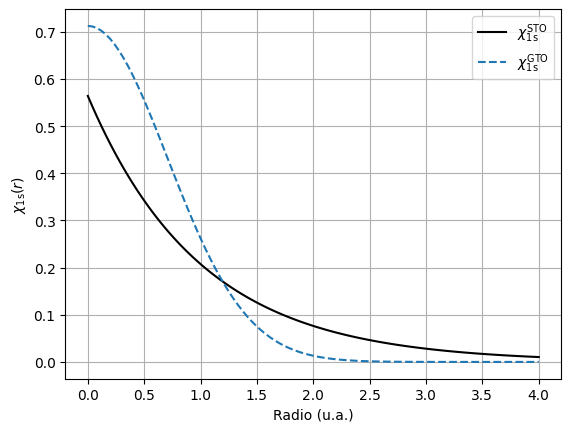

In [10]:
plt.plot(r, chi_STO_1s, label=r'$\chi_{1\mathrm{s}}^{\mathrm{STO}}$', color='k')
plt.plot(r, chi_GTO_1s, label=r'$\chi_{1\mathrm{s}}^{\mathrm{GTO}}$', linestyle='dashed')

plt.xlabel('Radio (u.a.)')
plt.ylabel(r'$\chi_{1\mathrm{s}}(r)$')
plt.grid()
plt.legend()
plt.show()

---
## (2) Contracción Gaussiana: STO-$k\,$G <a class="anchor" id="section_2"></a>

Se busca aproximar a la función original de tipo Slater `STO(n, l, m, zeta, r, theta, phi)` planteando a la parte radial de la misma como una combinación lineal de $k$ funciones Gaussianas, i.e.
$$
R_{n}^{\mathrm{STO}} (\zeta, r) \approx R_{nl}^{k}(\zeta, \vec{d}, \vec{\alpha}, r) = \sum_{i=1}^{k} d_i R_{l}^{\mathrm{GTO}} (\zeta^2 \alpha_i, r) \,,
$$

de lo cual la aproximación para la función original de tipo Slater luciría como:
$$ \chi_{nlm}^{\mathrm{STO}}(\zeta, \vec{d}, \vec{\alpha}, r, \theta, \phi)
\approx \chi_{nlm}^{k}(\zeta, \vec{d}, \vec{\alpha}, r, \theta,\phi)
= R_{nl}^{k}(\zeta, \vec{d}, \vec{\alpha}, r) Y_{lm}(\theta,\phi)$$

In [11]:
def R_STO_nG(z, d, a, l, r):
    """
        Combinación lineal de Gaussianas (parte radial)
    z : exponente orbital de Slater
    d : vector de coeficientes
    a : vector de exponentes orbitales Gaussianos
    l : número cuántico azimutal
    r : coordenada radial
    """
    suma = 0
    # calcular cada uno de los k términos de la combinación lineal
    for i in range(len(d)):
        suma += d[i] * R_GTO(l, np.power(z,2)*a[i], r) # k-ésimo término
    
    return suma

In [12]:
def STO_nG(z, d, a, l, m, r, theta, phi):
    """
        Combinación lineal de Gaussianas
    z : exponente de Slater
    d : vector de coeficientes
    a : vector de exponentes Gaussianos
    l : número cuántico azimutal
    m : número cuántico magnético
    r : coordenada radial
    theta : coordenada polar
    phi: coordenada azimutal
    """
    suma = 0
    for i in range(len(d)): # calcular cada uno de los k términos de la suma
        suma += d[i] * GTO(l, m, np.power(z,2)*a[i], r, theta, phi) # término k-ésimo
    
    return suma

<div class="alert alert-block alert-info">
<strong>Observación.</strong> Conforme el número de términos en la contracción Gaussiana se puede aumentar la precisión de la aproximación tanto para la función original y su distribución radial. Por la literatura [2] se sabe que para aproximar una función $\ket{1s}$ de Slater, una 3-contracción de Gaussianas es suficiente.
</div>

### (2.1) Condición de normalización <a class="anchor" id="section_2_1"></a>

Dado que la función original $\chi_{nlm}^{\mathrm{STO}} (\zeta, \vec{d}, \vec{\alpha}, r, \theta, \phi)$ se encuentra normalizada, se impone la condición de normalización para la aproximación de esta, la función $\chi_{nlm}^{k}(\zeta, \vec{d}, \vec{\alpha}, r, \theta,\phi)$:
$$
1 = \langle \, \chi_{nlm}^{k} \, | \, \chi_{nlm}^{k} \, \rangle
= \int |R_{nl}^{k} \, Y_{lm}|^2 \, \mathrm{d}V
= \int r^2 |R_{nl}^{k}| \mathrm{d}r \, \int |Y_{lm}|^2 \, \mathrm{d}\Omega
= \int r^2 |R_{nl}^{k}| \mathrm{d}r
= \int r^2 \Big|\sum_{i=1}^{k} d_i \, R_{l}^{\mathrm{GTO}} (\zeta^2 \alpha_i, r) \Big|^2 \, \mathrm{d}r \,.
$$

Recuerde que $(\sum_i a_i)^2 = \sum_i a_i^2 + 2\sum_{i<j} a_i a_j$ para $a\in \mathbb{R}$. Así, como $R_l^{\mathrm{GTO}}: \mathbb{R} \to \mathbb{R}$ la expresión previa no es más que
$$
\begin{align*}
1 &= \int r^2 \sum_{i=1}^{k} d_i^2 R_l^{\mathrm{GTO}}(\zeta^2 \alpha_i, r)^2 \mathrm{d}r
+ 2\int r^2 \left(\sum_{i<j} d_i d_j R_l^{\mathrm{GTO}}(\zeta^2 \alpha_i, r) R_l^{\mathrm{GTO}}(\zeta^2 \alpha_j, r) \right) \mathrm{d}r\\
&= \sum_{i=1}^{k} \left( d_i^2 \int r^2 R_l^{\mathrm{GTO}}(\zeta^2 \alpha_i, r)^2 \mathrm{d}r \right)
+ 2 \sum_{i<j} \left( d_i d_j \int r^2 R_l^{\mathrm{GTO}}(\zeta^2 \alpha_i, r) R_l^{\mathrm{GTO}}(\zeta^2 \alpha_j, r) \mathrm{d}r \right)
\end{align*}
$$

Además, ya que $R_l^{\mathrm{GTO}}(\alpha, r)$ está normalizada, entonces
$$
\begin{align*}
1 &= \sum_{i=1}^{k} d_i^2
+ 2 \sum_{i<j} \left( d_i d_j \int r^2 R_l^{\mathrm{GTO}}(\zeta^2 \alpha_i, r) R_l^{\mathrm{GTO}}(\zeta^2 \alpha_j, r)  \mathrm{d}r \right) \,.
\end{align*}
$$

<div class="alert alert-block alert-info">
Revisar la normalización la función $R_{l}^{\mathrm{GTO}}(\alpha,r)$. Aún no me sale :(
</div>

Se denotará por $I_1(i,j)$ a la integral de la siguiente forma:

$$
\begin{align*}
I_1(i,j) &= \int r^2 R_{l}^{\mathrm{GTO}} (\alpha_i, r) R_{l}^{\mathrm{GTO}} (\alpha_j, r) \, \mathrm{d}r \\
&= \Bigg[ \frac{2(2 a_i)^{3/4}}{\pi^{1/4}} \Bigg] \Bigg[ \frac{2(2 a_j)^{3/4}}{\pi^{1/4}} \Bigg]
\Bigg[ \frac{2^l}{(2l+1)!!} \Bigg] (\sqrt{2a_i})^l (\sqrt{2a_j})^l
\int_{0}^{\infty} r^{2(l+1)} \exp[-(\alpha_i + \alpha_j)r^2] \, \mathrm{d}r \\
&= \frac{2^2 2^{3/2} 2^{2l} (\alpha_i \alpha_j)^{3/4} (\alpha_i \alpha_j)^{l/2}}{\pi^{1/2} (2l+1)!!} \int_{0}^{\infty} r^{2(l+1)} \exp[-(\alpha_i + \alpha_j)r^2] \, \mathrm{d}r \,.
\end{align*}
$$

<div class="alert alert-block alert-info">
Averiguar si esa integral tiene solución
</div>
Denótese a $k = 2l+1$ donde $l = 0, 1, 2, \dots, n-1$ y además $\alpha = \alpha_i + \alpha_j$. De tal modo esta última integral no es más que
$$
\int_{0}^{\infty} r^{2(l+1)} \exp[-(\alpha_i + \alpha_j)] \, \mathrm{d}r
= \int_{0}^{\infty} r^{k} \exp[-\alpha r^2] \, \mathrm{d}r
$$

Restringiéndonos al caso de interés, i.e. las funciones $\ket{1s}$, se tendría que
$$
I_1(i,j) = \frac{2^2 2^{3/2} (\alpha_i \alpha_j)^{3/4}}{\pi^{1/2}} \int_{0}^{\infty} r^{2} \exp[-(\alpha_i + \alpha_j) r^2] \, \mathrm{d}r \\
= \frac{2^2 2^{3/2} (\alpha_i \alpha_j)^{3/4}}{\pi^{1/2}} \cdot \frac{\pi^{1/2}}{4(\alpha_i + \alpha_j)^{3/2}} \\
= \frac{2^{3/2} (\alpha_i \alpha_j)^{3/4}}{(\alpha_i + \alpha_j)^{3/2}}
$$

Resulta trivial notar que $I(i,i)=1$.

La condición de normalización para la contracción de $k$ Gaussianas $\ket{1s}$ será entonces
$$
\begin{align}
\boxed{1 = \sum_{i=1}^{k} d_i^2 + 2 \sum_{i<j} \left( d_i d_j \frac{2^{3/2} (\alpha_i \alpha_j)^{3/4}}{(\alpha_i + \alpha_j)^{3/2}} \right)}
\end{align}
$$

En este trabajo se buscarán los parámetros para una contracción Gaussiana $\ket{1s}$ de 3 términos. Es decir $k=3$, en cuyo caso la condición de normalización será:
$$
\boxed{
1 = d_1^2 + d_2^2 + d_3^2
+ 2 d_1 d_2 \frac{2^{3/2} (\alpha_1 \alpha_2)^{3/4}}{(\alpha_1 + \alpha_2)^{3/2}}
+ 2 d_1 d_3 \frac{2^{3/2} (\alpha_1 \alpha_3)^{3/4}}{(\alpha_1 + \alpha_3)^{3/2}}
+ 2 d_2 d_3 \frac{2^{3/2} (\alpha_2 \alpha_3)^{3/4}}{(\alpha_2 + \alpha_3)^{3/2}}}
$$

In [13]:
def cond_norm(d, a):
    """
        Condición de normalización para una k-contracción de Gaussianas
    d : vector de coeficientes, len(d) > 1
    a : vector de exponentes orbitales Gaussianos
    """
    termino1 = sum(np.square(d))
    termino2 = 0
    
    k = len(d)
    for i in range(k-1):
        for j in range(i+1,k):
            termino2 += d[i] * d[j] * np.power(2, 1.5) * np.power(a[i]*a[j], 0.75) / np.power(a[i]+a[j], 1.5)

    return termino1 + 2*termino2

### (2.2) Función de error <a class="anchor" id="section_2_2"></a>

No solo es relevante los parámetros de la aproximación preserven la normalización, también es importante la función de distribución radial sea preservada. En otras palabras, se busca minimizar a la función de error $\epsilon$ dada por
$$
\epsilon
= \Big\langle \phi - \chi \, \Big| \, \phi - \chi \Big\rangle
$$

donde $\phi$ es la función original y $\chi$ la $k$-contracción Gaussiana, dadas por:
$$
\begin{align}
    \phi &:= R_{n}^{\mathrm{STO}}(\zeta, r) \\
    \chi &:= R_{nl}^{k}(\zeta, \vec{d}, \vec{\alpha}, r)
\end{align}
$$

No se consideran a las partes angulares de ambas funciones pues los armónicos esféricos están normalizados. Explícitamente, el problema de minimización sería:
$$
\epsilon := \epsilon_{nl}^{k}(\zeta, \vec{d}, \vec{\alpha})
= \Big\langle R_{n}^{\mathrm{STO}}(\zeta, r) - R_{nl}^{k}(\zeta, \vec{d}, \vec{\alpha}, r) \, \Big| \,
    R_{n}^{\mathrm{STO}}(\zeta, r) - R_{nl}^{k}(\zeta, \vec{d}, \vec{\alpha}, r) \Big\rangle
$$

no obstante, nos restringiremos a usar la primer notación introducida por simplicidad.

Considere el siguiente desarrollo para el problema de minimización en cuestión:
$$
\begin{align}
    \epsilon &= \int |\phi - \chi|^2 \,\mathrm{d}\tau \\
    &= \underbrace{\int \phi^{*}\phi \,\mathrm{d}\tau}_{1} + \underbrace{\int \chi^{*}\chi \,\mathrm{d}\tau}_{1} - \int \chi^{*}\phi \,\mathrm{d}\tau - \int \phi^{*}\chi \,\mathrm{d}\tau \\
    &= 2 - \int \chi^{*}\phi \,\mathrm{d}\tau - \int \phi^{*}\chi \,\mathrm{d}\tau
\end{align}
$$

Para el caso de una aproximación de una función $\ket{1s}$ de Slater, ambas funciones $\phi$ y $\chi$ son reales. Por lo cual el problema de minimización de interés a resolver será:
$$
\begin{align*}
    \epsilon = 2 - 2 \int \phi \, \chi \, \mathrm{d}\tau
\end{align*}
$$

Como la función de error $\epsilon$ debe ser minimizada, obtener el máximo para esta última integral (conocida como integral de traslape, $S$ ) es equivalente a resolver el problema original.
$$
\boxed{S = \int_{0}^{\infty} r^2 R_{n}^{\mathrm{STO}}(\zeta, r) \, R_{nl}^{k}(\zeta, \vec{d}, \vec{\alpha}, r) \, \mathrm{d}r}
$$

A partir de la condición de normalización y la maximización de $S$ se cuenta con los criterios necesarios para encontrar los parámetros que ajustarán del mejor modo a la contracción de 3 Gaussianas sobre la función de Slater $\ket{1s}$.

En el trabajo original de 1969 de Robert F. Stewart [2] se explica cómo calcular a los parámetros de la $k$-contracción mediante la matriz de mínimos cuadrados. Para que la función de error $\epsilon$ sea un mínimo respecto a los parámetros Gaussianos $P_j$ (los coeficientes de la contracción $d_j$ y los exponentes orbitales $\alpha_j$) debe ocurrir que $\partial \epsilon / \partial P_j = 0$, con $j = 1, 2, \dots, 2k$. A partir de esto es posible hacer una expansión en Taylor de $\partial \epsilon / \partial P_j$ a primer orden alrededor de un conjunto de parámetros iniciales $\mathbf{P}^0$ y así obtener una ecuación matricial que involucra a la Hessiana de $\epsilon$.

En este trabajo se tomará un camino diferente, en mayor parte gracias a las herramientas computacionales de hoy día. Para determinar a los parámetros de la $k$-contracción emplearemos a la función `minimize` de la paquetería *SciPy* (v1.14.1) la cual toma a la función por minimizar ($\epsilon$), las restricciones a considerar (condición de normalización), el intervalo de los parámetros a considerar ($\alpha_i$ > 0, $\forall \alpha_i$) y un conjunto de parámetros iniciales $\mathbf{P}^0$. Para el conjunto $\mathbf{P}^0$ los valores serán generados a partir de la función `rand()` de *Numpy* (v2.2.1) la cual devuelve un número aleatorio entre 0 y 1.

In [14]:
from scipy.optimize import minimize
from scipy.integrate import quad

In [15]:
# Función original: R_STO(1s), z = 1
def f(r):
    return R_STO(1, 1, r)

# Aproximación parametrizada: R_STO-3G(1s), z = 1
def g(r, params):
    d1, d2, d3, a1, a2, a3 = params
    d = [d1, d2, d3]
    a = [a1, a2, a3]
    return R_STO_nG(1, d, a, 0, r) # Note que `R_STO_nG` no está normalizada

# Condición de normalización
def cond(params):
    d1, d2, d3, a1, a2, a3 = params
    d = [d1, d2, d3]
    a = [a1, a2, a3]
    return cond_norm(d,a) - 1

In [16]:
# sys.float_info.epsilon = diferencia más pequeña entre 1 y el siguiente 'float' posible de ser representado
epsilon = sys.float_info.epsilon

# Función por minimizar:
def error(params):
    """
        Función de error
    params : (d1, d2, ..., dk, a1, a2, ..., ak)
    """
    integrand = lambda x: (x**2) * f(x) * g(x,params)
    integral, _ = quad(integrand, epsilon, np.inf)
    return 2 - 2*integral

In [17]:
# vector de parámetros iniciales P^0
# el orden de los parámetros es (d1, d2, ..., dk, a1, a2, ..., ak)
params_inicial = np.random.rand(1,6)[0].tolist()
print("Parámetros iniciales:", params_inicial)

# intervalos que toma cada parámetro Gaussiano
bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (epsilon, np.inf), (epsilon, np.inf), (epsilon, np.inf)]

# restricciones del problema (condición de normalización)
con = {'type': 'eq', 'fun': cond}

Parámetros iniciales: [0.38577147610909057, 0.3371574219966289, 0.2550118057905508, 0.5645086992826365, 0.7188536335615386, 0.7171124437904604]


In [18]:
# Problema de minimización
%time result3G = minimize(error, params_inicial, bounds=bounds, constraints=[con])

CPU times: total: 11.4 s
Wall time: 12.6 s


In [19]:
# Revisión de condición de normalización para R_STO-3G
d3G = result3G.x[:len(result3G.x)//2]
a3G = result3G.x[len(result3G.x)//2:]

print("Parámetros óptimos:", result3G.x)
print("Error en la condición de normalización:", abs((cond_norm(d3G, a3G)-1)*100), "%")
print("Valor función de error:", result3G.fun)

Parámetros óptimos: [0.44471812 0.53527165 0.15430005 0.10983311 0.40584959 2.22794903]
Error en la condición de normalización: 2.453886118747306e-05 %
Valor función de error: 0.00033028231272380637


### (2.3) Visualización <a class="anchor" id="section_2_3"></a>

In [20]:
n = 1
z = 1 # exponente orbital de tipo Slater
R_STO_1s = R_STO(n, z, r) # función radial de tipo Slater |1s>

xdata = np.linspace(0,4,100) # dominio de graficación
ydata = [R_STO_nG(1, d3G, a3G, 0, r)]
labels = [r'$R^{\mathrm{STO-3G}}_{1\mathrm{s}}$']

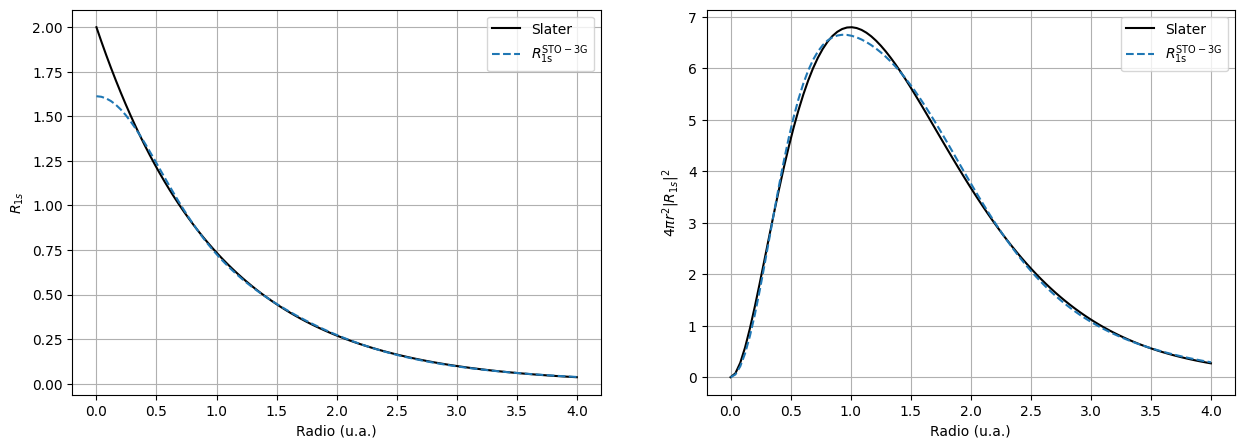

In [21]:
comparar_funcs(xdata, R_STO_1s, ydata, labels)

---
## (3) STO-3G en la literatura <a class="anchor" id="section_3"></a>

En esta sección se determinará el error en la condición de normalización y el valor de la función de error a partir de los parámetros $P_j$ reportados por Stewart [2, pág. 2487]. Mas aún, se compararán visualmente las funciones radiales y de distribución radial obtenidas en el presente trabajo y las de Stewart.

A continuación se reportan los parámetros encontrados en el presente trabajo (Segura) y aquellos por Stewart.
|  Parámetro  |    $d_1$   |    $d_2$   |    $d_3$   | $\alpha_1$ | $\alpha_2$ | $\alpha_3$ |
|:------------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|    Segura   | 0.444718   | 0.535272   | 0.154300   | 0.109833   | 0.405850   | 2.22795    |
|   Stewart   | 0.444635   | 0.535328   | 0.154329   | 0.109818   | 0.405771   | 2.22766    |

El conjunto de parámetros iniciales $\mathbf{P}^{0}$ empleados en este trabajo se hayan en la siguiente tabla:
| Parámetro |   $d_1$  |   $d_2$  |   $d_3$  |$\alpha_1$|$\alpha_2$|$\alpha_3$|
|:----------|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|   Valor   | 0.385772 | 0.337157 | 0.255012 | 0.564509 | 0.718854 | 0.717112 |

Se desconoce el conjunto de parámetros iniciales empleados por Stewart, por lo que estos no son reportados.

Cabe ser mencionado que todos los valores pertenecientes a este trabajo reportados en las tablas previas están redondeados a 6 cifras de precisión decimal para coincidir en longitud con los reportados por Stewart. Los valores reales poseen una precisión decimal de 17 dígitos y se encuentran impresos al final de este archivo de Jupyter en el [Apéndice](#apendice).

In [22]:
# Parámetros obtenidos por Stewart
dMod = [0.444635, 0.535328, 0.154329]
aMod = [0.109818, 0.405771, 2.22766]
print("Error en la condición de normalización:", abs((cond_norm(dMod, aMod)-1)*100), "%")

Error en la condición de normalización: 0.0001425997864235029 %


In [23]:
xdata = np.linspace(0,4,100) # dominio de graficación
ydata = [R_STO_nG(1, d3G, a3G, 0, r), R_STO_nG(1, dMod, aMod, 0, r)]
labels = [r'$R^{\mathrm{STO-3G}}_{1\mathrm{s}}$', 'Stewart']

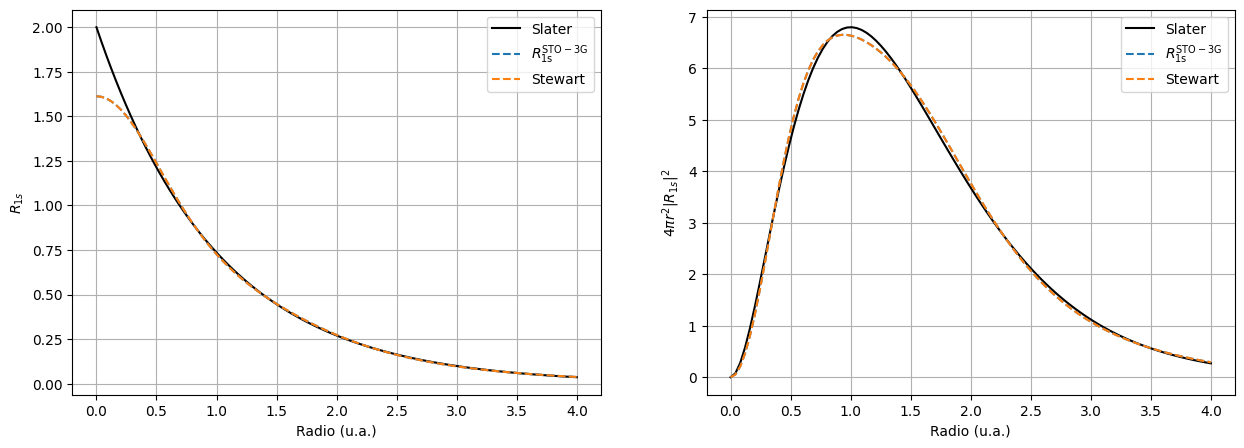

In [24]:
comparar_funcs(xdata, R_STO_1s, ydata, labels)

Los parámetros de Stewart y los hayados son tan cercanos que no es posible apreciar una diferencia entre las curvas generadas a partir de dichos parámetros.

A continuación se reportan el error porcentual de la condición de normalización y el valor de la función de error.
|  Valor  | Normalización |   Error  |
|:--------|:--------------|:---------|
|  Segura |   2.454e-5 %  | 3.303e-4 |
| Stewart |   1.426e-4 %  | 3.305e-4 |

---
## Referencias <a class="anchor" id="referencias"></a>

[1] a

[2] Robert F. Stewart. Small Gaussian Expansions of Atomic Orbitals. The Journal of Chemical Physics 50, 2485 (1969); doi: 10.1063/1.1671406

---
## Apéndice <a class="anchor" id="apendice"></a>

Se reportan los valores completos de los coeficientes de contracción $d_i$ y de los exponentes orbitales Gaussianos $\alpha_i$ para un STO-3G.

In [43]:
np.set_printoptions(threshold=np.inf) # remueve el truncamiento al imprimir arreglos

print("Coeficientes de contracción:", d3G.tolist())
print("Exponentes orbitales Gaussianos:", a3G.tolist())

Coeficientes de contracción: [0.44471812476789035, 0.5352716544572346, 0.1543000507808527]
Exponentes orbitales Gaussianos: [0.10983311305458726, 0.40584959263313375, 2.227949029647934]
